In [1]:
from tensorflow.keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *

from mnist_utils import load_mnist_data, load_mnist_predictor, animate_mnist_examples


2021-12-09 07:09:19.153294: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2021-12-09 07:09:21.755753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 07:09:21.757833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-09 07:09:21.786087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:09:21.787027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.3

In [2]:
#Load MNIST data

x_train, y_train, x_test, y_test = load_mnist_data()

#Load MNIST predictor

predictor_path = 'saved_models/mnist_binarized_cnn_10_digits.h5'
predictor = load_mnist_predictor(predictor_path)


n train samples = 11552
n test samples = 1888
x_train.shape = (11552, 28, 28, 2)


2021-12-09 07:09:23.579020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-09 07:09:23.600406: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


In [3]:
#Calculate background

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=0) + pseudo_count) / (x_train.shape[0] + 2. * pseudo_count)


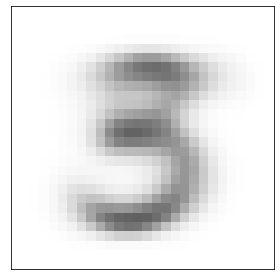

In [4]:
#Visualize background image distribution

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean[..., 1], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [5]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.mean(kl_divs, axis=(1, 2))
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 0.36095130083827087


In [6]:
#Define image template

onehot_template = np.zeros(x_mean.shape)


In [7]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 7,
    'mask_smoothing_std' : 1.5,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    scrambler_mode='inclusion',
    n_classes=10,
    input_size_x=28,
    input_size_y=28,
    n_out_channels=2,
    input_templates=[onehot_template],
    input_backgrounds=[x_mean],
    batch_size=32,
    n_samples=32,
    sample_mode='st',
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config
)


In [8]:
#Train scrambler

n_epochs = 10

train_history = scrambler.train(
    predictor,
    x_train,
    y_train,
    x_test,
    y_test,
    n_epochs,
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 361 : 10},
    nll_mode='reconstruction',
    predictor_task='classification',
    entropy_mode='target',
    entropy_bits=0.005,
    entropy_weight=1200.
)


/home/ubuntu/anaconda3/envs/python_3_8_tf2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-12-09 07:09:30.850281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-09 07:09:31.203038: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Train on 11552 samples, validate on 1888 samples
Epoch 1/10
11552/11552 [==============================] - 61s 5ms/sample - loss: 1.8831 - nll_loss: 1.5163 - entropy_loss: 0.3668 - val_loss: 0.7817 - val_nll_loss: 0.6347 - val_entropy_loss: 0.1470
Epoch 2/10
11552/11552 [==============================] - 53s 5ms/sample - loss: 1.1405 - nll_loss: 1.0087 - entropy_loss: 0.1318 - val_loss: 0.7047 - val_nll_loss: 0.6104 - val_entropy_loss: 0.0943
Epoch 3/10
11552/11552 [==============================] - 53s 5ms/sample - loss: 1.0355 - nll_loss: 0.9049 - entropy_loss: 0.1306 - val_loss: 0.6246 - val_nll_loss: 0.4812 - val_entropy_loss: 0.1435
Epoch 4/10
11552/11552 [==============================] - 54s 5ms/sample - loss: 0.9659 - nll_loss: 0.8376 - entropy_loss: 0.1283 - val_loss: 0.5948 - val_nll_loss: 0.4974 - val_entropy_loss: 0.0975
Epoch 5/10
11552/11552 [==============================] - 49s 4ms/sample - loss: 0.9153 - nll_loss: 0.7925 - entropy_loss: 0.1228 - val_loss: 0.5471 - val_

In [9]:
#Save scrambler checkpoint
save_dir = 'saved_models'

model_name = 'mnist_inclusion_scrambler_target_bits_0005_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models/mnist_inclusion_scrambler_target_bits_0005_epochs_10.h5 


In [10]:
#Load models
save_dir = 'saved_models'

model_name = 'mnist_inclusion_scrambler_target_bits_0005_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models/mnist_inclusion_scrambler_target_bits_0005_epochs_10.h5 


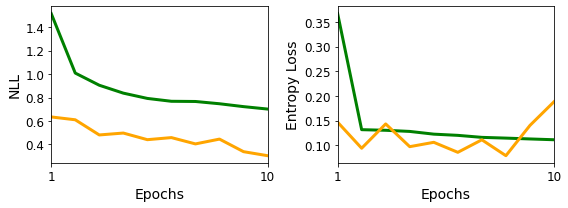

In [11]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [12]:
#Interpret the test set using the trained scrambler

image_test, sample_test, importance_scores_test = scrambler.interpret(x_test)


Test image 0:


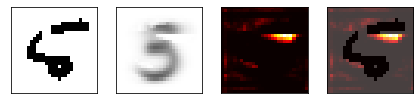

Test image 1:


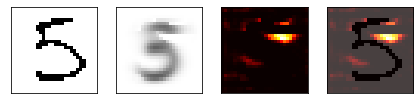

Test image 2:


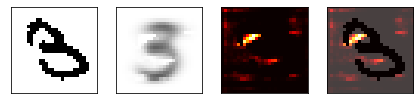

Test image 3:


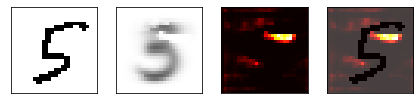

Test image 4:


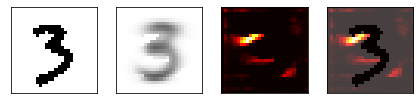

Test image 5:


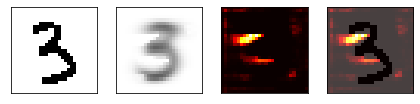

Test image 6:


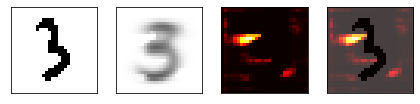

Test image 7:


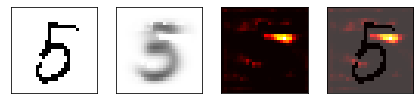

Test image 8:


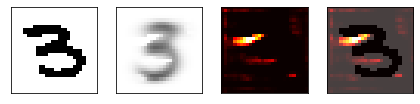

Test image 9:


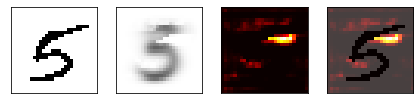

In [13]:
#Visualize a few reconstructed images

plot_examples = np.arange(10).tolist()
save_examples = []

for test_ix in plot_examples :
    
    print("Test image " + str(test_ix) + ":")
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(1.5 * 4, 1.5))

    ax1.imshow(x_test[test_ix, :, :, 1], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[test_ix, :, :, 1], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(importance_scores_test[test_ix, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[test_ix, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[test_ix, :, :, 1], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(importance_scores_test[test_ix, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[test_ix, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    if save_figs :
        plt.savefig(model_name + "_test_ix_" + str(test_ix) + ".png", transparent=True, dpi=300)
        plt.savefig(model_name + "_test_ix_" + str(test_ix) + ".eps")
    
    plt.show()
